In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import elasticdeform
import h5py
from PIL import Image, ImageOps

np.random.seed(10)

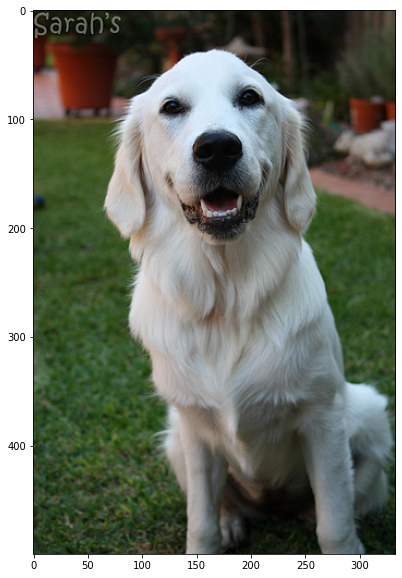

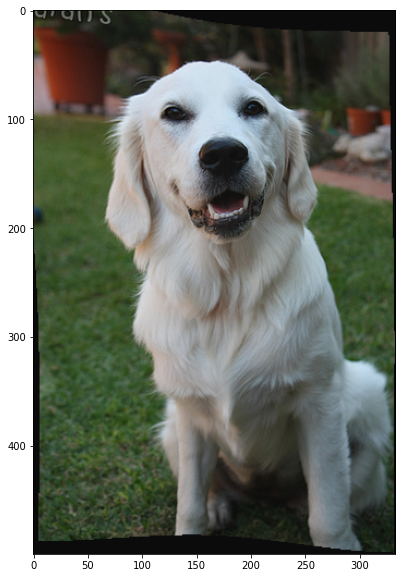

In [62]:
#Testing some elastic deform

def normalize(img):
    return (img - np.min(img)) / (np.max(img) - np.min(img))

hf = h5py.File('/mikQNAP/NYU_knee_data/knee_train_h5/data/train/223_12.h5', 'r')
print(hf)
im = hf.get('dataset_name').value


np_im = normalize(np.array(im))


# This method will show image in any image viewer 
plt.figure(figsize=(10,10))
plt.imshow(np_im) 

deform = elasticdeform.deform_random_grid(np_im, 10, axis=(0, 1))  #15-30
plt.figure(figsize=(10,10))
plt.imshow(normalize(deform))

In [ ]:
# Set Up Registration Dataset
class RegistrationDataset(Dataset):
    def __init__(self, data_paths, transform=None, target_transform=None):
        self.data_paths = data_paths  # Could be a list: ['./train/input/image_1.bmp', './train/input/image_2.bmp', ...]
        self.transform = transforms
        self.target_transform = target_transform
        
    def __getitem__(self, index):
        
        #TODO: input: magnitude of transformed mr image, output: magnitude of original mr image

        
        #Select Image 1 and apply Normalization Transforms (fixed output)
        
        #Load Mr image
        #normalize im(image domain)/95% percentile (image domain) --> images should be normalized but just in case
        #take image magnitude
        #apply transforms
        im = np.array(Image.open(self.data_paths[index]))  #TODO: fix this
        imT = im
        if self.transform:
            im = self.transform(im)
            
        #Apply Smooth Transform to Image 2 (moving input)
        if self.target_transform:
            imT = self.target_transform(imT)

        return imT, im  
    def __len__(self):
        return len(self.data_paths)

In [52]:
#Set Up Elastic Deform Transform
class ElasticDeform(object):
    """Performs elastic deformation on an image.
    Args:
        sig_min = minimum of range of standard deviation of the normal distribution
        sig_max = maximum of range of standard deviation of the normal distribution
    """

    def __init__(self, sig_min, sig_max):
        self.sig_min = sig_min  #15
        self.sig_max = sig_max  #30

    def __call__(self, img):
        """
        Args:
            img (np array): Image to be deformed elastically
        Returns:
            np array: Elastic Deformed image.
        """
        np_im = normalize(np.array(img))
        sig = random.randrange(sig_min, aig_max+1)
        if img.ndim == 3:
            deform = elasticdeform.deform_random_grid(np_im, sig, axis=(0, 1))
        elif img.ndim == 2:
            deform = elasticdeform.deform_random_grid(np_im, 10)
        
        return deform

    def __repr__(self):
        return self.__class__.__name__


In [1]:
#Loading Data and Setting Up Transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
target_transform = transforms.Compose(
    [ElasticDeform(15, 30), 
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = RegistrationDataset("/mikQNAP/NYU_knee_data/knee_train_h5/data/train", transform, target_transform)

trainset = RegistrationDataset("/mikQNAP/NYU_knee_data/knee_train_h5/data/test", transform, target_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


In [ ]:
#Visualize Data

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel=(3,3))
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel=(3,3))
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out) #Todo: do we want a relu?
        return out

In [ ]:
class DownsampleBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(DownsampleBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel=(3,3), stride=2)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.pool = nn.MaxPool2d(3) #check with alfredo about kernel size
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel=(3,3))
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out1 = F.relu(self.bn1(self.conv1(x)))
        out2 = self.pool(x)
        
        out = torch.cat((out1, out2))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

In [ ]:


class RegistrationNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Pre Concat (ran twice in parallelish)
        #In channels should be 1 because magnitude
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel = (3,3))
        self.bn1 = nn.BatchNorm2d(32)
        self.resnet1 = ResidualBlock(32, 32)
        self.downsample1 = Downsampleblock(32, 64)
        self.resnet21 = ResidualBlock(64, 64)
        self.resnet22 = ResidualBlock(64, 64)
        self.downsample2 = Downsampleblock(64, 128)
        self.resnet3 = ResidualBlock(128, 128)
        
    
        #Post Concat
        self.conv2 = nn.Conv2d(in_channels = 256, out_channels = 128, kernel = (3,3))
        self.bn2 = nn.BatchNorm2d(128)
        self.resnet41 = ResidualBlock(128, 128)
        self.resnet42 = ResidualBlock(128, 128)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel = (3,3))
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = 2, kernel = (3,3))
        self.bn4 = nn.BatchNorm2d(2)  #should contain deformation field

    def forward(self, x):
        x1 = F.relu(self.bn1(self.conv1(x)))
        x1 = self.downsample(self.resnet1(x1))
        x1 = self.downsample2(self.resnet22(self.resnet21(x1)))
        x1 = self.resnet3(x1)
        
#         x2 = F.relu(self.bn1(self.conv1(x[1])))
#         x2 = self.downsample(self.resnet1(x2))
#         x2 = self.downsample2(self.resnet22(self.resnet21(x2)))
#         x2 = self.resnet3(x2) #Will this make the weights be shared?
        
#         x = torch.cat((x1, x2))
        
        x = F.relu(self.bn2(self.conv2(x1)))
        x = self.resnet42(self.resnet41(x))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        return x


net = RegistrationNet()

In [ ]:
#Set up loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#Train Model
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

In [ ]:
#Save Model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
# Visualize Test Data
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))

In [ ]:
# Run Network on Sample of Test Data
net = RegistrationNet()
net.load_state_dict(torch.load(PATH))

outputs = net(images)
_, predicted = torch.max(outputs, 1)


In [ ]:
#Run Network on All Test Data
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))